#Activity Recognition from Single Chest-Mounted Accelerometer Data Set 

Uncalibrated Accelerometer Data are collected from 15 participantes performing 7 activities. The dataset provides challenges for identification and authentication of people using motion patterns.

####Data Set Information:

- The dataset collects data from a wearable accelerometer mounted on the chest 

- Sampling frequency of the accelerometer: 52 Hz 

- Accelerometer Data are Uncalibrated 

- Number of Participants: 15 

- Number of Activities: 7 

- Data Format: CSV

####Attribute Information:

- Data are separated by participant 

- Each file contains the following information 

- sequential number, x acceleration, y acceleration, z acceleration, label 

- Labels are codified by numbers 
    - 1: Working at Computer 
    - 2: Standing Up, Walking and Going up/down stairs 
    - 3: Standing 
    - 4: Walking 
    - 5: Going Up/Down Stairs 
    - 6: Walking and Talking with Someone 
    - 7: Talking while Standing

####Analysis:
- Import data from UCI Machine Learning Repository: http://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer#

- Create new features

- Visualize Data

- Classify the data using three methodologies. In this case I'm using:
    - Linear Regression,
    - Support Vector Machines (SVM), 
    - K-Nearest Neighbor (KNN), and 
    - Decision Trees / Random Forest

- Compute Measures of Prediction Goodness
    - Accuracy
    - Precision
    - Correlation
    - F1 
    - Recall
    - AUC
- Create a Confusion Matrix

- Display ROC Curve

####Remarks:

I will first classify the data using Linear Regression, which one can easily assume will not be able to do the job sufficiently. I will then increase the models in complexity by using SVM to classify, and then Random Forest. With each model, I will print out prediction measures. I will then create a confusion matrix and an ROC Curve using data from the best model.

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as skm
import sklearn.ensemble as sk
import pylab as pl
import numpy as np
from sklearn.cross_validation import train_test_split
from scipy.stats.stats import pearsonr
import datetime as dt
from sklearn.metrics import classification_report

In [3]:
%matplotlib inline

###Import Data

####Note: 
Combining all 15 sets of data is a bit too much for my computer to handle. I will just be combining three for now and proceeding accordingly. I will still write the code for combining and working with all 15 sets, but I will leave the extra code commented out.

In [121]:
column_names = ['xval', 'yval', 'zval', 'activity']
part1 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/1.csv', header=None, names=column_names)
# part2 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/2.csv', header=None, names=column_names)
# part3 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/3.csv', header=None, names=column_names)
# part4 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/4.csv', header=None, names=column_names)
# part5 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/5.csv', header=None, names=column_names)
part6 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/6.csv', header=None, names=column_names)
# part7 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/7.csv', header=None, names=column_names)
# part8 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/8.csv', header=None, names=column_names)
# part9 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/9.csv', header=None, names=column_names)
# part10 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/10.csv', header=None, names=column_names)
part11 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/11.csv', header=None, names=column_names)
# part12 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/12.csv', header=None, names=column_names)
# part13 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/13.csv', header=None, names=column_names)
# part14 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/14.csv', header=None, names=column_names)
# part15 = pd.read_csv('/Users/molliepettit/Desktop/Data Science/Projects/Accelerometer/15.csv', header=None, names=column_names)

###Add Features

In brainstorming for adding features, I created all potential features I could think of, with disregard for redundancy or overfitting. I later commented out all I found unnecessary. And later, you'll see that I disregard the features found to be less important.

####Features created and notes:
- xdiff, ydiff, zdiff
    - The difference between row n and row n+1 for each axis
- xdiff_abs, ydiff_abs, zdiff_abs
    - Absolute value of xdiff, ydiff, and zdiff
    - Likely don't need both xdif fand xdiff_abs
- av_resultant_acc
    - Average Resultant Acceleration
    - sqrt(x^2 + y^2 + z^2)
- xvy, xvz, yvz
    - Ratio of x/y, x/z, and y/z
- angle_x-y, angle_y-x, angle_z-y, angle_y-z, angle_x-z, angle_z-x
    - If one creates a right triangle using two of the vectors created from the xdiff, ydiff, or zdiff values, these will be the resulting non-90-degree angles
    - Only one of each pair is needed, as each pair are sets of complimentary angles, and are therefor inversely related. Therefore, I commented out every other angle.
- x_avg, y_avg, z_avg
    - Average of each axis
    - Given each activity, I found the average values of each axis for each participant
    - This is not very useful unless given a data set that you know includes one, and only one, activity. Therefore, this section is commented out. 
- x_std, y_std, z_std
    - Standard deviation for each axis
    - Again, this is not very useful unless given a data set that you know includes one, and only one, activity. This section is also commented out.
    
    
    
      

In [5]:
def add_features(df):
    #Difference in values from one row to the next
    df["xdiff"] = df["xval"].diff(-1)
    df["ydiff"] = df["yval"].diff(-1)
    df["zdiff"] = df["zval"].diff(-1)
    df["xdiff_abs"] = abs(df["xdiff"])
    df["ydiff_abs"] = abs(df["ydiff"])
    df["zdiff_abs"] = abs(df["zdiff"])
    
    #Average Resultant Acceleration: sqrt(x^2 + y^2 + z^2)
    df["av_resultant_acc"] = np.sqrt((df['xval'])**2 + (df['yval'])**2 + (df['zval'])**2)
    
    #Calculate ratio of x axis to y axis, x axis to z axis, and y axis to z axis
    df['xvy'] = df['xdiff_abs']/df['ydiff_abs']
    df['xvz'] = df['xdiff_abs']/df['zdiff_abs']
    df['yvz'] = df['ydiff_abs']/df['zdiff_abs']
    
    #Calculate various angles
    #Only one of each pair is needed, as each pair are sets of complimentary angles, and are therefor inversely proportional
    df['angle_x-y'] = abs(np.arcsin(df['ydiff']/(np.sqrt(df['xdiff']**2 + df['ydiff']**2))))
#     df['angle_y-x'] = np.arcsin(df['xdiff']/(np.sqrt(df['xdiff']**2 + df['ydiff']**2)))
    df['angle_z-y'] = abs(np.arcsin(df['ydiff']/(np.sqrt(df['zdiff']**2 + df['ydiff']**2))))
#     df['angle_y-z'] = np.arcsin(df['zdiff']/(np.sqrt(df['zdiff']**2 + df['ydiff']**2)))
    df['angle_x-z'] = abs(np.arcsin(df['zdiff']/(np.sqrt(df['xdiff']**2 + df['zdiff']**2))))
#     df['angle_z-x'] = np.arcsin(df['xdiff']/(np.sqrt(df['xdiff']**2 + df['zdiff']**2)))

#     #Find Average Values of each axis
#     #X-axis
#     df['x_avg'] = ""
#     df['x_avg'][df['activity']==1] = np.mean(df['xval'][df['activity']==1])
#     df['x_avg'][df['activity']==2] = np.mean(df['xval'][df['activity']==2])
#     df['x_avg'][df['activity']==3] = np.mean(df['xval'][df['activity']==3])
#     df['x_avg'][df['activity']==4] = np.mean(df['xval'][df['activity']==4])
#     df['x_avg'][df['activity']==5] = np.mean(df['xval'][df['activity']==5])
#     df['x_avg'][df['activity']==6] = np.mean(df['xval'][df['activity']==6])
#     df['x_avg'][df['activity']==7] = np.mean(df['xval'][df['activity']==7])

#     #y-axis
#     df['y_avg'] = ""
#     df['y_avg'][df['activity']==1] = np.mean(df['yval'][df['activity']==1])
#     df['y_avg'][df['activity']==2] = np.mean(df['yval'][df['activity']==2])
#     df['y_avg'][df['activity']==3] = np.mean(df['yval'][df['activity']==3])
#     df['y_avg'][df['activity']==4] = np.mean(df['yval'][df['activity']==4])
#     df['y_avg'][df['activity']==5] = np.mean(df['yval'][df['activity']==5])
#     df['y_avg'][df['activity']==6] = np.mean(df['yval'][df['activity']==6])
#     df['y_avg'][df['activity']==7] = np.mean(df['yval'][df['activity']==7])

#     #z-axis
#     df['z_avg'] = ""
#     df['z_avg'][df['activity']==1] = np.mean(df['zval'][df['activity']==1])
#     df['z_avg'][df['activity']==2] = np.mean(df['zval'][df['activity']==2])
#     df['z_avg'][df['activity']==3] = np.mean(df['zval'][df['activity']==3])
#     df['z_avg'][df['activity']==4] = np.mean(df['zval'][df['activity']==4])
#     df['z_avg'][df['activity']==5] = np.mean(df['zval'][df['activity']==5])
#     df['z_avg'][df['activity']==6] = np.mean(df['zval'][df['activity']==6])
#     df['z_avg'][df['activity']==7] = np.mean(df['zval'][df['activity']==7])
    
#     #Find Standard Deviation for each axis
#     #x-axis
#     df['x_std'] = ""
#     df['x_std'][df['activity']==1] = np.std(df['xval'][df['activity']==1])
#     df['x_std'][df['activity']==2] = np.std(df['xval'][df['activity']==2])
#     df['x_std'][df['activity']==3] = np.std(df['xval'][df['activity']==3])
#     df['x_std'][df['activity']==4] = np.std(df['xval'][df['activity']==4])
#     df['x_std'][df['activity']==5] = np.std(df['xval'][df['activity']==5])
#     df['x_std'][df['activity']==6] = np.std(df['xval'][df['activity']==6])
#     df['x_std'][df['activity']==7] = np.std(df['xval'][df['activity']==7])

#     #y-axis
#     df['y_std'] = ""
#     df['y_std'][df['activity']==1] = np.std(df['yval'][df['activity']==1])
#     df['y_std'][df['activity']==2] = np.std(df['yval'][df['activity']==2])
#     df['y_std'][df['activity']==3] = np.std(df['yval'][df['activity']==3])
#     df['y_std'][df['activity']==4] = np.std(df['yval'][df['activity']==4])
#     df['y_std'][df['activity']==5] = np.std(df['yval'][df['activity']==5])
#     df['y_std'][df['activity']==6] = np.std(df['yval'][df['activity']==6])
#     df['y_std'][df['activity']==7] = np.std(df['yval'][df['activity']==7])

#     #z-axis
#     df['z_std'] = ""
#     df['z_std'][df['activity']==1] = np.std(df['zval'][df['activity']==1])
#     df['z_std'][df['activity']==2] = np.std(df['zval'][df['activity']==2])
#     df['z_std'][df['activity']==3] = np.std(df['zval'][df['activity']==3])
#     df['z_std'][df['activity']==4] = np.std(df['zval'][df['activity']==4])
#     df['z_std'][df['activity']==5] = np.std(df['zval'][df['activity']==5])
#     df['z_std'][df['activity']==6] = np.std(df['zval'][df['activity']==6])
#     df['z_std'][df['activity']==7] = np.std(df['zval'][df['activity']==7])
    
    return df
        

In [122]:
add_features(part1)
# add_features(part2)
# add_features(part3)
# add_features(part4)
# add_features(part5)
add_features(part6)
# add_features(part7)
# add_features(part8)
# add_features(part9)
# add_features(part10)
add_features(part11)
# add_features(part12)
# add_features(part13)
# add_features(part14)
# add_features(part15)

,xval,yval,zval,activity,xdiff,ydiff,zdiff,xdiff_abs,ydiff_abs,zdiff_abs,av_resultant_acc,xvy,xvz,yvz,angle_x-y,angle_z-y,angle_x-z
0,1983,2438,1825,1,35,-4,28,35,4,28,3634.110345,8.750000,1.250000,0.142857,0.113792,0.141897,0.674741
1,1948,2442,1797,1,21,54,13,21,54,13,3603.786481,0.388889,1.615385,4.153846,1.199905,1.334551,0.554307
2,1927,2388,1784,1,-33,69,-47,33,69,47,3549.440660,0.478261,0.702128,1.468085,1.124691,0.972827,0.958644
3,1960,2319,1831,1,-7,45,-40,7,45,40,3545.690624,0.155556,0.175000,1.125000,1.416478,0.844154,1.397551
4,1967,2274,1871,1,-24,22,-11,24,22,11,3541.300044,1.090909,2.181818,2.000000,0.741947,1.107149,0.429762
5,1991,2252,1882,1,-19,-11,-11,19,11,11,3546.478394,1.727273,1.727273,1.000000,0.524796,0.785398,0.524796
6,2010,2263,1893,1,-27,-29,-26,27,29,26,3569.974510,0.931034,1.038462,1.115385,0.821097,0.839890,0.766532
7,2037,2292,1919,1,-4,-14,-6,4,14,6,3617.346265,0.285714,0.666667,2.333333,1.292497,1.165905,0.982794
8,2041,2306,1925,1,-2,8,12,2,8,12,3631.658299,0.250000,0.166667,0.666667,1.325818,0.588003,1.405648
9,2043,2298,1913,1,45,-38,29,45,38,29,3621.356376,1.184211,1.551724,1.310345,0.701260,0.918927,0.572460


####Combine the three participant files into one dataframe:

In [123]:
frames = [part1, part6, part11]
# frames = [part1, part2, part3, part4, part5, part6, part7, part8, part9, part10, part11, part12, part13, part14, part15]

In [124]:
df = pd.concat(frames, ignore_index=True)

In [9]:
df

,xval,yval,zval,activity,xdiff,ydiff,zdiff,xdiff_abs,ydiff_abs,zdiff_abs,av_resultant_acc,xvy,xvz,yvz,angle_x-y,angle_z-y,angle_x-z
0,1502,2215,2153,1,-165,143,106,165,143,106,3434.768988,1.153846,1.556604,1.349057,0.714091,0.932913,0.571031
1,1667,2072,2047,1,56,115,141,56,115,141,3355.932359,0.486957,0.397163,0.815603,1.117638,0.684183,1.192738
2,1611,1957,1906,1,10,18,75,10,18,75,3171.435952,0.555556,0.133333,0.240000,1.063698,0.235545,1.438245
3,1601,1939,1831,1,-42,-26,-48,42,26,48,3110.543843,1.615385,0.875000,0.541667,0.554307,0.496423,0.851966
4,1643,1965,1879,1,39,6,-42,39,6,42,3176.683018,6.500000,0.928571,0.142857,0.152649,0.141897,0.822418
5,1604,1959,1921,1,-36,130,-19,36,130,19,3178.165823,0.276923,1.894737,6.842105,1.300643,1.425670,0.485622
6,1640,1829,1940,1,33,-81,30,33,81,30,3130.246156,0.407407,1.100000,2.700000,1.183921,1.216091,0.737815
7,1607,1910,1910,1,61,-135,0,61,135,0,3143.031817,0.451852,inf,inf,1.146403,1.570796,0.000000
8,1546,2045,1910,1,17,-4,-62,17,4,62,3196.911165,4.250000,0.274194,0.064516,0.231091,0.064427,1.303180
9,1529,2049,1972,1,-108,71,27,108,71,27,3228.780884,1.521127,4.000000,2.629630,0.581565,1.207403,0.244979


In [10]:
list(df.columns.values)

['xval',
 'yval',
 'zval',
 'activity',
 'xdiff',
 'ydiff',
 'zdiff',
 'xdiff_abs',
 'ydiff_abs',
 'zdiff_abs',
 'av_resultant_acc',
 'xvy',
 'xvz',
 'yvz',
 'angle_x-y',
 'angle_z-y',
 'angle_x-z']

####Clean / Prepare data
Change inf and Nan values to a number so that the models will run.

In [125]:
df = df.replace([np.inf, -np.inf], np.nan)
print('xval nulls:', df['xval'].isnull().sum())
print('yval nulls:', df['yval'].isnull().sum())
print('zval nulls:', df['zval'].isnull().sum())
print('xdiff nulls:', df['xdiff'].isnull().sum())
print('ydiff nulls:', df['ydiff'].isnull().sum())
print('zdiff nulls:', df['zdiff'].isnull().sum())
print('av_resultant_acc nulls:', df['av_resultant_acc'].isnull().sum())
print('xvy nulls:', df['xvy'].isnull().sum())
print('xvz nulls:', df['xvz'].isnull().sum())
print('yvz nulls:', df['yvz'].isnull().sum())
print('angle_x-y nulls:', df['angle_x-y'].isnull().sum())
print('angle_z-y nulls:', df['angle_z-y'].isnull().sum())
print('angle_x-z nulls:', df['angle_x-z'].isnull().sum())

xval nulls: 0
yval nulls: 0
zval nulls: 0
xdiff nulls: 3
ydiff nulls: 3
zdiff nulls: 3
av_resultant_acc nulls: 0
xvy nulls: 30025
xvz nulls: 29656
yvz nulls: 29656
angle_x-y nulls: 2810
angle_z-y nulls: 2823
angle_x-z nulls: 2716


In [11]:
# df = df.replace([np.inf, -np.inf], 0)
df = df.replace(np.nan, 0)

###View Data

####Histograms

Amount of each activity

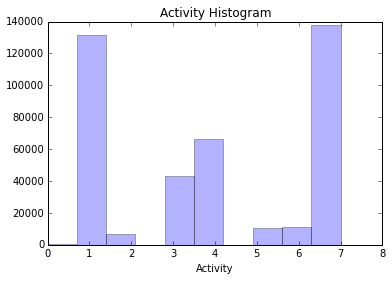

In [82]:
pl.hist(df['activity'], alpha = 0.3)
pl.xlabel('Activity')
pl.title('Activity Histogram')
pl.show()

Create Function for mass Histogram plotting

In [12]:
df1=df[df['activity']==1]
df2=df[df['activity']==2]
df3=df[df['activity']==3]
df4=df[df['activity']==4]
df5=df[df['activity']==5]
df6=df[df['activity']==6]
df7=df[df['activity']==7]
# df1.to_csv('df1.csv')
# df2.to_csv('df2.csv')
# df3.to_csv('df3.csv')

In [57]:
def plotfigs(value, x_label, title):
    df1[value].hist(label = 'Working at Computer', alpha = 0.2, normed=True,  color='blueviolet')
    df2[value].hist(label = 'Standing up, Walking, and Going updownstairs', alpha = 0.5, normed=True, color='dodgerblue')
    df3[value].hist(label = 'Standing', alpha = 0.5, normed=True, color='green')
    df4[value].hist(label = 'Walking', alpha = 0.5, normed=True, color='fuchsia')
    df5[value].hist(label = 'Going up/downstairs', alpha = 0.5, normed=True, color='orange')
    df6[value].hist(label = 'Walking and Talking with Someone', alpha = 0.5, normed=True, color='red')
    df7[value].hist(label = 'Talking while Standing', alpha = 0.3, normed=True, color='springgreen')
    pl.xlabel(x_label)
    pl.legend(bbox_to_anchor=(2.0, 1.025))
    pl.title(title)
    pl.show()

Histograms of x, y, and z values for each activity

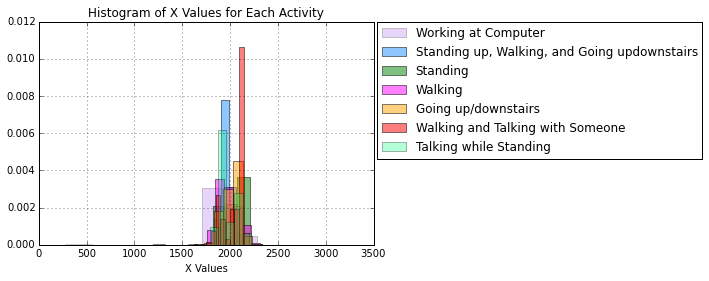

In [58]:
plotfigs('xval', 'X Values', 'Histogram of X Values for Each Activity')

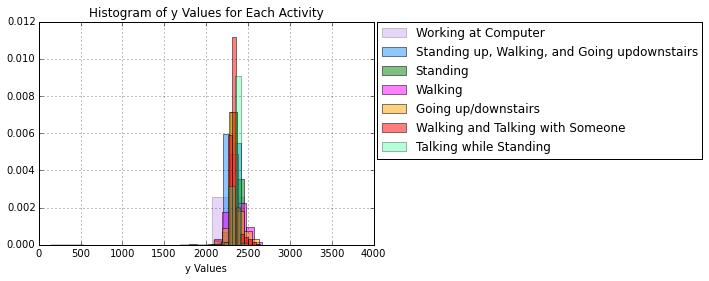

In [59]:
plotfigs('yval', 'y Values', 'Histogram of y Values for Each Activity')

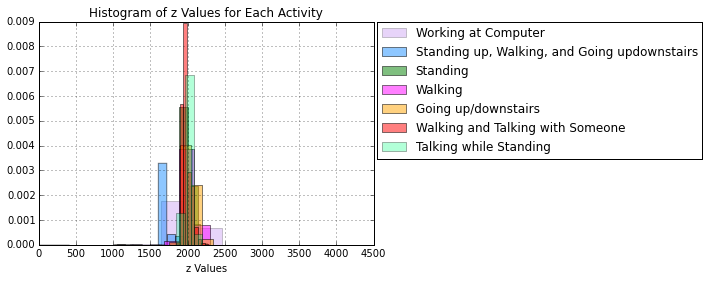

In [60]:
plotfigs('zval', 'z Values', 'Histogram of z Values for Each Activity')

Histograms of delta x, delta y, and delta z values for each activity

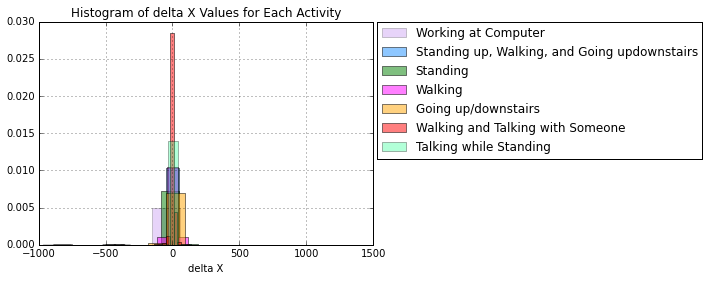

In [61]:
plotfigs('xdiff', 'delta X', 'Histogram of delta X Values for Each Activity')

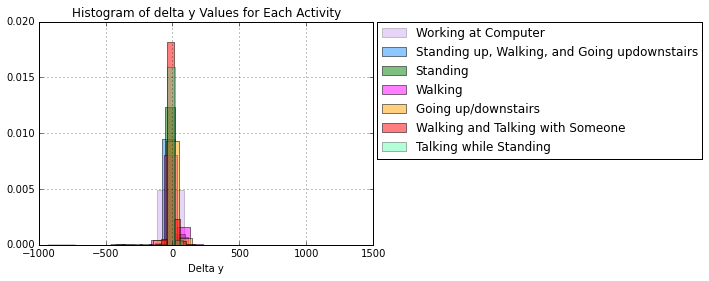

In [62]:
plotfigs('ydiff', 'Delta y', 'Histogram of delta y Values for Each Activity')

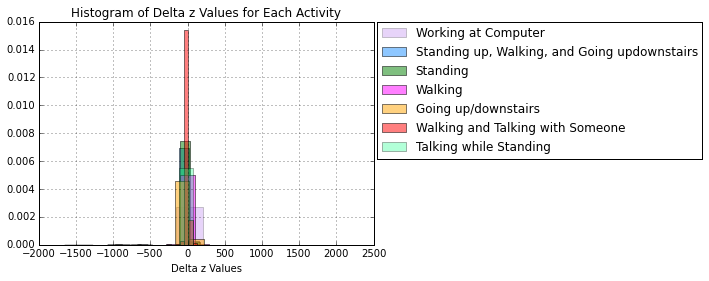

In [63]:
plotfigs('zdiff', 'Delta z Values', 'Histogram of Delta z Values for Each Activity')

Histogram of Average Resultant Acceleration for each activity

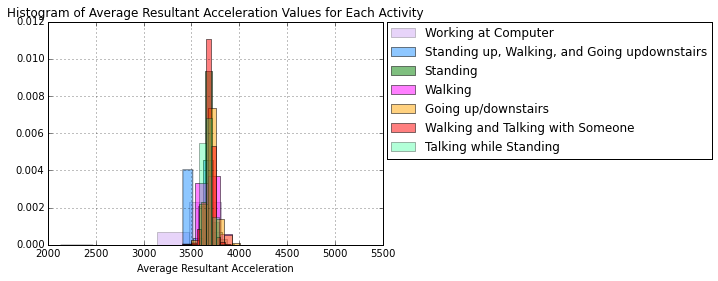

In [64]:
plotfigs('av_resultant_acc', 'Average Resultant Acceleration', 'Histogram of Average Resultant Acceleration Values for Each Activity')


Ratio plots

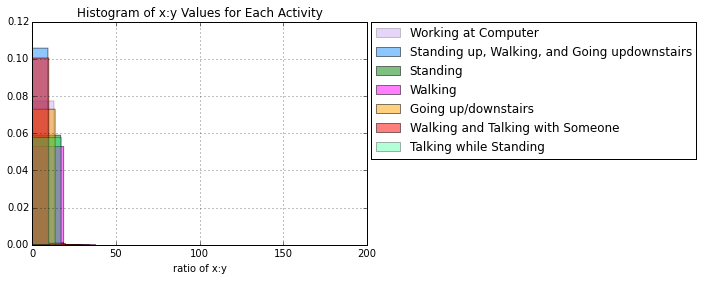

In [65]:
plotfigs('xvy', 'ratio of x:y', 'Histogram of x:y Values for Each Activity')

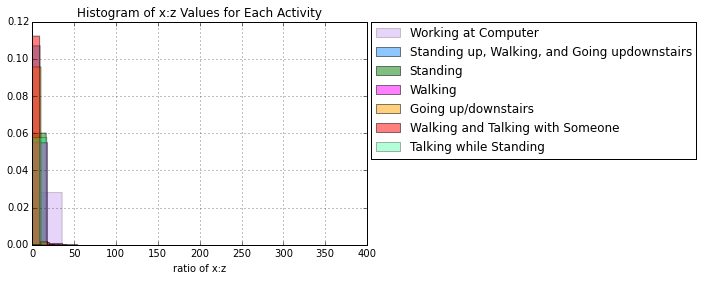

In [66]:
plotfigs('xvz', 'ratio of x:z', 'Histogram of x:z Values for Each Activity')

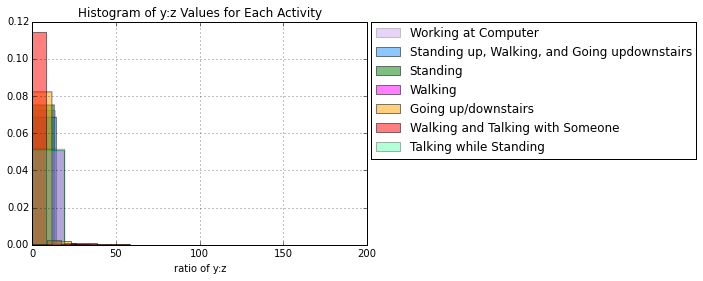

In [67]:
plotfigs('yvz', 'ratio of y:z', 'Histogram of y:z Values for Each Activity')

Angle Plots

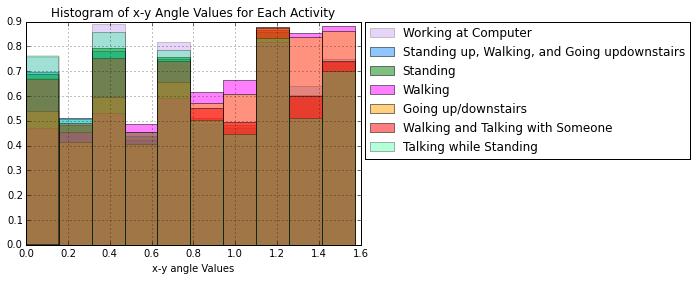

In [68]:
plotfigs('angle_x-y', 'x-y angle Values', 'Histogram of x-y Angle Values for Each Activity')

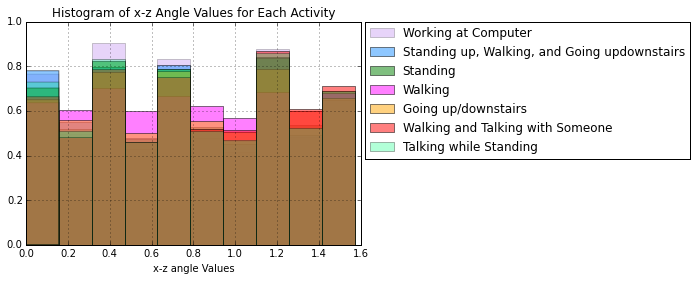

In [69]:
plotfigs('angle_x-z', 'x-z angle Values', 'Histogram of x-z Angle Values for Each Activity')

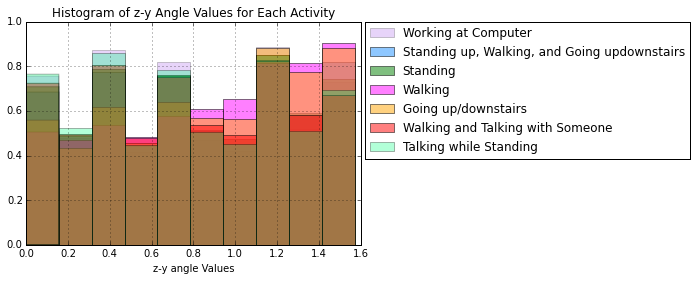

In [70]:
plotfigs('angle_z-y', 'z-y angle Values', 'Histogram of z-y Angle Values for Each Activity')

####Clustering

In [50]:
def create_scatter(x, y, title):
    pl.scatter(df1[x], df1[y], label = 'Working at Computer', color='blueviolet', alpha=0.5)
    pl.scatter(df2[x], df2[y], label = 'Standing up, Walking, and going UpDownstairs', color='dodgerblue', alpha=0.5)
    pl.scatter(df3[x], df3[y], label = 'Standing', color='green', alpha=0.5)
    pl.scatter(df4[x], df4[y], label = 'Walking', color='fuchsia', alpha=0.5)
    pl.scatter(df5[x], df5[y], label = 'Going up/downstairs', color='orange', alpha=0.5)
    pl.scatter(df6[x], df6[y], label = 'Walking and Talking with Someone', color='red', alpha=0.5)
    pl.scatter(df7[x], df7[y], label = 'Talking while Standing', color='springgreen', alpha=0.5)
    pl.legend(bbox_to_anchor=(2.0, 1.025))
    pl.xlabel(x)
    pl.ylabel(y)
    pl.title(title)
    pl.show()

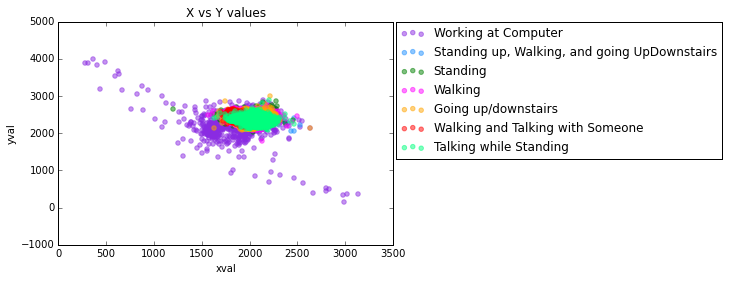

In [51]:
create_scatter('xval', 'yval', 'X vs Y values')

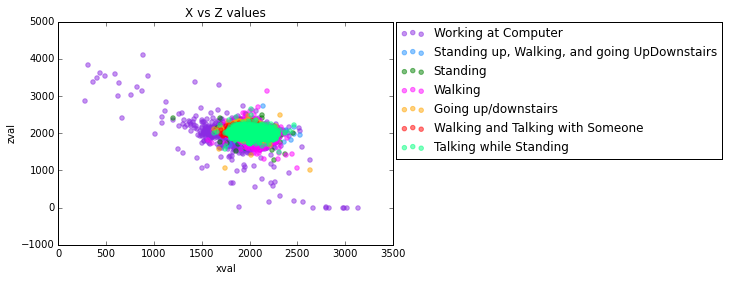

In [52]:
create_scatter('xval', 'zval', 'X vs Z values')

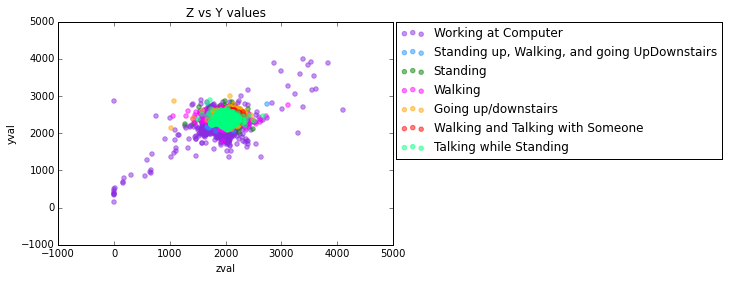

In [53]:
create_scatter('zval', 'yval', 'Z vs Y values')

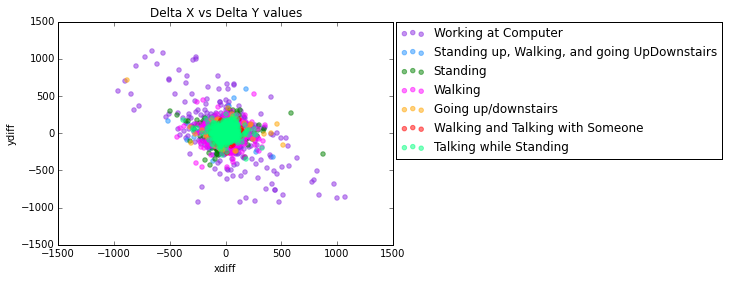

In [54]:
create_scatter('xdiff', 'ydiff', 'Delta X vs Delta Y values')

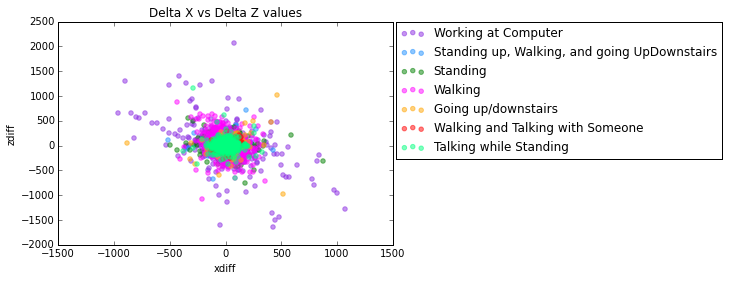

In [55]:
create_scatter('xdiff', 'zdiff', 'Delta X vs Delta Z values')

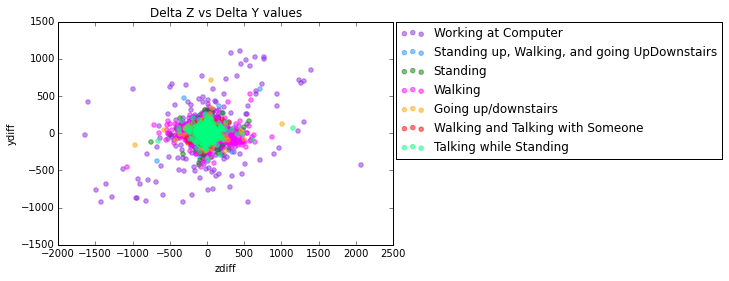

In [56]:
create_scatter('zdiff', 'ydiff', 'Delta Z vs Delta Y values')

####Box Plots

In [84]:
def create_boxplot(feature):
    data = [df1[feature], df2[feature], df3[feature], df4[feature], df5[feature], df6[feature], df7[feature]]
    pl.boxplot(data)
    pl.title(feature)
    pl.show()

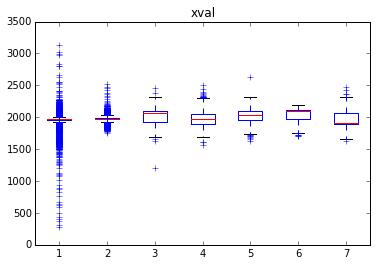

In [85]:
create_boxplot('xval')

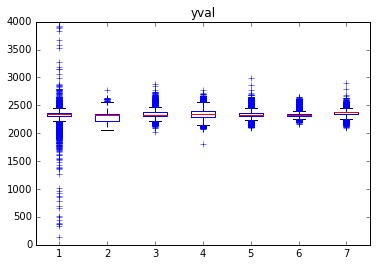

In [86]:
create_boxplot('yval')

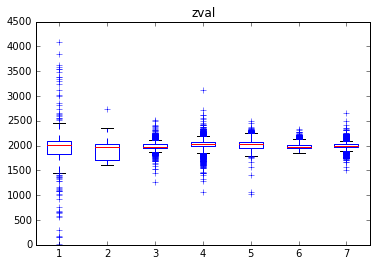

In [87]:
create_boxplot('zval')

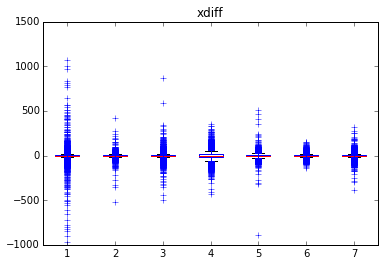

In [88]:
create_boxplot('xdiff')

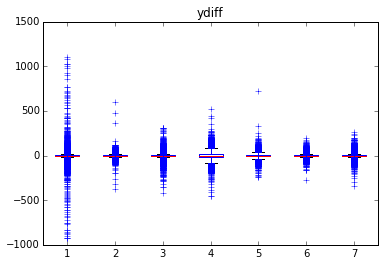

In [89]:
create_boxplot('ydiff')

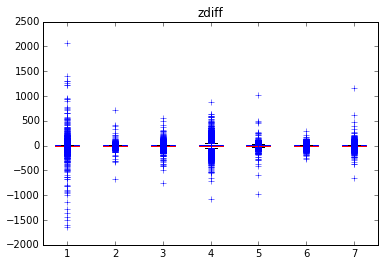

In [90]:
create_boxplot('zdiff')

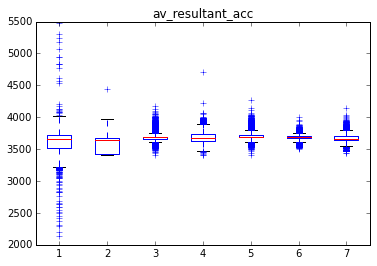

In [91]:
create_boxplot('av_resultant_acc')

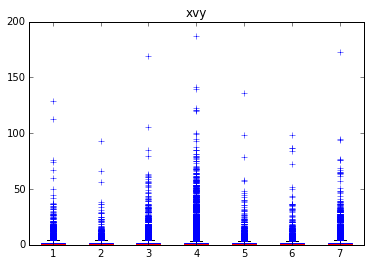

In [92]:
create_boxplot('xvy')

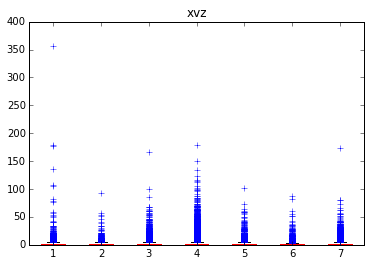

In [93]:
create_boxplot('xvz')

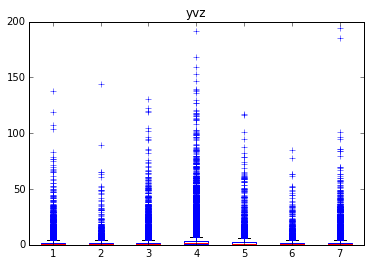

In [94]:
create_boxplot('yvz')

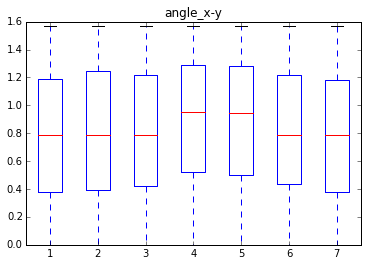

In [95]:
create_boxplot('angle_x-y')

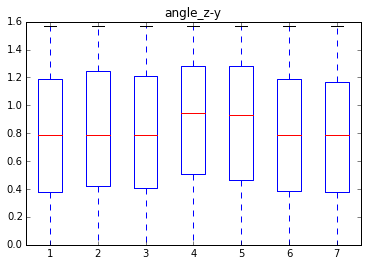

In [96]:
create_boxplot('angle_z-y')

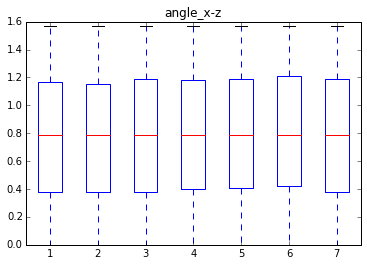

In [97]:
create_boxplot('angle_x-z')

In [14]:
#3d plots
# from mpl_toolkits.mplot3d import Axes3D

In [99]:
# Axes3D.scatter(df1['xval'], df1['yval'], df1['zval'], label = 'Working at Computer', color='blueviolet', alpha=0.5)
# Axes3D.scatter(df2['xval'], df2['yval'], df2['zval'], label = 'Standing up, Walking, and going UpDownstairs', color='dodgerblue', alpha=0.5)
# Axes3D.scatter(df3['xval'], df3['yval'], df3['zval'], label = 'Standing', color='seagreen', alpha=0.5)
# Axes3D.scatter(df4['xval'], df4['yval'], df4['zval'], label = 'Walking', color='fuchsia', alpha=0.5)
# Axes3D.scatter(df5['xval'], df5['yval'], df5['zval'], label = 'Going up/downstairs', color='orange', alpha=0.5)
# Axes3D.scatter(df6['xval'], df6['yval'], df6['zval'], label = 'Walking and Talking with Someone', color='red', alpha=0.5)
# Axes3D.scatter(df7['xval'], df7['yval'], df7['zval'], label = 'Talking while Standing', color='grey', alpha=0.5)
# axes3D.set_xlabel('X Values')
# axes3D.set_ylabel('Y Values')
# axes3D.set_zlabel('Z Values')
# pl.legend(bbox_to_anchor=(2.0, 1.025))



##Linear Regression:

####Split the data into training and test sets

In [10]:
X = df[['xval', 'yval', 'zval', 'xdiff', 'ydiff', 'zdiff', 'av_resultant_acc', 'xvy', 'xvz', 'yvz','angle_x-y', 'angle_z-y', 'angle_x-z']]
y = df['activity']
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.40)

- Labels are codified by numbers 
    - 1: Working at Computer 
    - 2: Standing Up, Walking and Going up/down stairs 
    - 3: Standing 
    - 4: Walking 
    - 5: Going Up/Down Stairs 
    - 6: Walking and Talking with Someone 
    - 7: Talking while Standing

In [13]:
# import statsmodels.api as sm
# linreg = sm.OLS(y,X)
# model_linear = linreg.fit(X_train, y_train)

from sklearn.linear_model import LinearRegression
model_linear = LinearRegression(n_jobs = 5)
model_linear.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=5, normalize=False)

In [15]:
linear_test_pred = model_linear.predict(X_test)

In [21]:
linear_test_pred = linear_test_pred.round().astype(int)

####Measures of Predictive Goodness

In [46]:
print("Accuracy = %f" %(skm.accuracy_score(y_test, linear_test_pred)))
print("Precision = %f" %(skm.precision_score(y_test, linear_test_pred)))
print("Recall = %f" %(skm.recall_score(y_test, linear_test_pred)))
print("F1 score = %f" %(skm.f1_score(y_test, linear_test_pred)))
print("Correlation = %f" %(pearsonr(y_test, linear_test_pred)[0]))

/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of

Accuracy = 0.095984
Precision = 0.352411
Recall = 0.095984
F1 score = 0.041504
Correlation = 0.243753


/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:960: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


####Remarks

As was assumed, the linear regression model is not at all sufficient for this problem, with an accuracy of < 10%.

##SVM

####Note:
I had planned to test the data on three different SVM models, but SVM seemed to be a bit too much for my computer to handle; therefore, this section was not fully run.

In [100]:
X = df[['xval', 'yval', 'zval', 'xdiff', 'ydiff', 'zdiff', 'av_resultant_acc']]
y = df['activity']
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.40)

####Linear

In [ ]:
t1 = dt.datetime.now()

from sklearn import svm
svc = svm.SVC(kernel = 'linear')
model_svm = svc.fit(X_train, y_train)

t2 = dt.datetime.now()      
print('Total feature query time: ', (t2-t1).seconds , 'sec')

In [ ]:
svm_test_pred = svc.predict(X_test)

In [ ]:
print("Accuracy = %f" %(skm.accuracy_score(y_test, svm_test_pred)))
print("Precision = %f" %(skm.precision_score(y_test, svm_test_pred)))
print("Recall = %f" %(skm.recall_score(y_test, svm_test_pred)))
print("F1 score = %f" %(skm.f1_score(y_test, svm_test_pred)))
print("Correlation = %f" %(pearsonr(y_test, svm_test_pred)[0]))

####Poly

In [ ]:
t1 = dt.datetime.now()

from sklearn import svm
svc = svm.SVC(kernel = 'poly')
model_svm = svc.fit(X_train, y_train)

t2 = dt.datetime.now()      
print('Total feature query time: ', (t2-t1).seconds , 'sec')

In [ ]:
svm_test_pred2 = svc.predict(X_test)

In [ ]:
print("Accuracy = %f" %(skm.accuracy_score(y_test, svm_test_pred2)))
print("Precision = %f" %(skm.precision_score(y_test, svm_test_pred2)))
print("Recall = %f" %(skm.recall_score(y_test, svm_test_pred2)))
print("F1 score = %f" %(skm.f1_score(y_test, svm_test_pred2)))
print("Correlation = %f" %(pearsonr(y_test, svm_test_pred2)[0]))

####rbf

In [ ]:
t1 = dt.datetime.now()

from sklearn import svm
svc = svm.SVC(kernel = 'rbf')
model_svm = svc.fit(X_train, y_train)

t2 = dt.datetime.now()      
print('Total feature query time: ', (t2-t1).seconds , 'sec')

In [ ]:
svm_test_pred3 = svc.predict(X_test)

In [ ]:
print("Accuracy = %f" %(skm.accuracy_score(y_test, svm_test_pred3)))
print("Precision = %f" %(skm.precision_score(y_test, svm_test_pred3)))
print("Recall = %f" %(skm.recall_score(y_test, svm_test_pred3)))
print("F1 score = %f" %(skm.f1_score(y_test, svm_test_pred3)))
print("Correlation = %f" %(pearsonr(y_test, svm_test_pred3)[0]))

##K Nearest Neighbor (KNN)

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
X = df[['xval', 'yval', 'zval', 'xdiff', 'ydiff', 'zdiff', 'av_resultant_acc', 'xvy', 'xvz', 'yvz','angle_x-y', 'angle_z-y', 'angle_x-z']]
y = df['activity']
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.40)

In [64]:
knn = KNeighborsClassifier()
model_knn = knn.fit(X_train, y_train)

In [65]:
knn_test_pred = knn.predict(X_test)

In [66]:
print("Accuracy = %f" %(skm.accuracy_score(y_test, knn_test_pred)))
print("Precision = %f" %(skm.precision_score(y_test, knn_test_pred)))
print("Recall = %f" %(skm.recall_score(y_test, knn_test_pred)))
print("F1 score = %f" %(skm.f1_score(y_test, knn_test_pred)))
print("Correlation = %f" %(pearsonr(y_test, knn_test_pred)[0]))

Accuracy = 0.800284
Precision = 0.785392

/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of


Recall = 0.800284
F1 score = 0.790368
Correlation = 0.862875


/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


####Remarks,

These results are much improved from the linear regression model, with an accuracy of 80%

##Random Forest

In [23]:
X = df[['xval', 'yval', 'zval', 'xdiff', 'ydiff', 'zdiff', 'av_resultant_acc', 'xvy', 'xvz', 'yvz','angle_x-y', 'angle_z-y', 'angle_x-z']]
y = df['activity']
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.40)

rfc = sk.RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs = 5 )
model = rfc.fit(X_train, y_train)

####Rank Features by Importance Score

In [36]:
fi = enumerate(rfc.feature_importances_)
cols =  ['xval', 'yval', 'zval', 'xdiff', 'ydiff', 'zdiff', 'av_resultant_acc', 'xvy', 'xvz', 'yvz','angle_x-y', 'angle_z-y', 'angle_x-z']
[(value, cols[i]) for (i,value) in fi if value > 0.0]

[(0.21353589559144448, 'xval'),
 (0.16931604721194221, 'yval'),
 (0.13639784532390356, 'zval'),
 (0.053621564362729544, 'xdiff'),
 (0.067766871513593535, 'ydiff'),
 (0.050045595384074888, 'zdiff'),
 (0.15294773306112577, 'av_resultant_acc'),
 (0.025454169656477673, 'xvy'),
 (0.024483874126312543, 'xvz'),
 (0.025176036771702433, 'yvz'),
 (0.026831910528659804, 'angle_x-y'),
 (0.026613311993146108, 'angle_z-y'),
 (0.027809144474887436, 'angle_x-z')]

In [37]:
fi = enumerate(rfc.feature_importances_)
cols =  ['xval', 'yval', 'zval', 'xdiff', 'ydiff', 'zdiff', 'av_resultant_acc', 'xvy', 'xvz', 'yvz','angle_x-y', 'angle_z-y', 'angle_x-z']
[(value, cols[i]) for (i,value) in fi if value > 0.05]

[(0.21353589559144448, 'xval'),
 (0.16931604721194221, 'yval'),
 (0.13639784532390356, 'zval'),
 (0.053621564362729544, 'xdiff'),
 (0.067766871513593535, 'ydiff'),
 (0.050045595384074888, 'zdiff'),
 (0.15294773306112577, 'av_resultant_acc')]

####Note:
Could potentially re-run the model, with only the top features.

####Measures of Predictive Goodness

In [38]:
rf_test_pred = rfc.predict(X_test)

In [45]:
print("Accuracy = %f" %(skm.accuracy_score(y_test, rf_test_pred)))
print("Precision = %f" %(skm.precision_score(y_test, rf_test_pred)))
print("Recall = %f" %(skm.recall_score(y_test, rf_test_pred)))
print("F1 score = %f" %(skm.f1_score(y_test, rf_test_pred)))
print("Correlation = %f" %(pearsonr(y_test, rf_test_pred)[0]))

Accuracy = 0.819366
Precision = 0.805485
Recall = 0.819366

/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score wit


F1 score = 0.800622
Correlation = 0.880135


/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


###Reduce Features

Because all of the new features were created from the x, y, and z values, all the features directly linked to one another. This could potentially lead to over-fitting. Therefore, it is beneficial to reduce the amount of unnecessary features. 

In [101]:
#Recall
y = df['activity']
X = df[['xval', 'yval', 'zval', 'xdiff', 'ydiff', 'zdiff', 'av_resultant_acc']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40)

In [102]:
t1 = dt.datetime.now()  

rfc = sk.RandomForestClassifier(n_estimators=50, oob_score=True, n_jobs = 5 )
model = rfc.fit(X_train, y_train)

t2 = dt.datetime.now()      
print('Total feature query time: ', (t2-t1).seconds , 'sec')

Total feature query time:  33 sec


In [103]:
rf_test_pred = rfc.predict(X_test)

In [98]:
print("Accuracy = %f" %(skm.accuracy_score(y_test, rf_test_pred)))
print("Precision = %f" %(skm.precision_score(y_test, rf_test_pred)))
print("Recall = %f" %(skm.recall_score(y_test, rf_test_pred)))
print("F1 score = %f" %(skm.f1_score(y_test, rf_test_pred)))
print("Correlation = %f" %(pearsonr(y_test, rf_test_pred)[0]))

/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1082: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy = 0.820843
Precision = 0.807098

/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:1172: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/molliepettit/anaconda/lib/python3.4/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of 


Recall = 0.820843
F1 score = 0.803613
Correlation = 0.882229


####Remarks:
Reducing the features to only those that were ranked as more important has increased all scores only slightly.


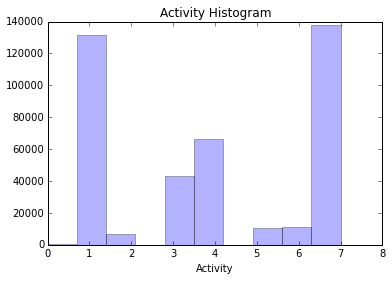

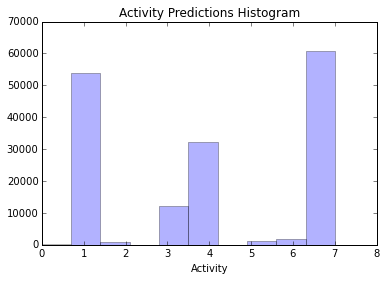

In [96]:
pl.hist(df['activity'], alpha = 0.3)
pl.xlabel('Activity')
pl.title('Activity Histogram')
pl.show()

pl.hist(rf_test_pred, alpha = 0.3)
pl.xlabel('Activity')
pl.title('Activity Predictions Histogram')
pl.show()

####Remarks:
As can be seen in these histograms, the model is less likely to predict activity 2, 5, or 6 ("standing up, walking, and going up/down stairs", "Going up/downstairs", and "Waling and Talking with someone", respectively).

###Confusion Matrix

In [104]:
cm = skm.confusion_matrix(y_test, rf_test_pred)

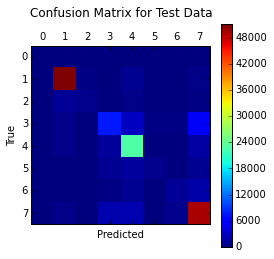

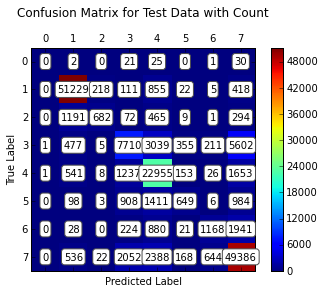

In [109]:
pl.matshow(cm)
pl.title('Confusion Matrix for Test Data\n'
         + '                               ')
pl.xlabel('Predicted')
pl.ylabel('True')
pl.colorbar()
pl.figure(figsize=(20,10))

fig, ax = pl.subplots()
im = ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
pl.title('Confusion Matrix for Test Data with Count\n'
         + '                               ')
fig.colorbar(im)
pl.xlabel('Predicted Label')
pl.ylabel('True Label')
pl.figure(figsize=(20,10))
pl.show()

####Remarks:

Looking at the confusion matrix, some of the frequenty mislabelings that stick out the most are (in format predicted : truth) 7:3, 4:3, 4:7, and 3:7. Values 3, 4, and 7 stand for "Standing", "Walking", and "Talking while Standing", respectively. 

By looking at the confusion matrix one can see that 1 and 7 ("Working at a computer" and "Talking while Standing", respectively) are the most successfully labeled, with 4 ("Standing") trailing behind in third. 

Labels 
- 1: Working at Computer 
- 2: Standing Up, Walking and Going up/down stairs 
- 3: Standing 
- 4: Walking 
- 5: Going Up/Down Stairs 
- 6: Walking and Talking with Someone 
- 7: Talking while Standing



###ROC Curve

In [59]:
fpr, tpr, thresholds = skm.roc_curve(y_test, rf_test_pred, pos_label=6)

In [60]:
skm.auc(fpr, tpr)

0.67997889961730174

In [61]:
fpr

array([ 0.        ,  0.3749756 ,  0.37972261,  0.38576654,  0.58598437,
        0.65709501,  0.66264158,  1.        ])

In [62]:
tpr

array([ 0.        ,  0.49500581,  0.7340302 ,  0.73681765,  0.95238095,
        0.99210221,  0.99233449,  1.        ])

In [63]:
thresholds

array([8, 7, 6, 5, 4, 3, 2, 1])

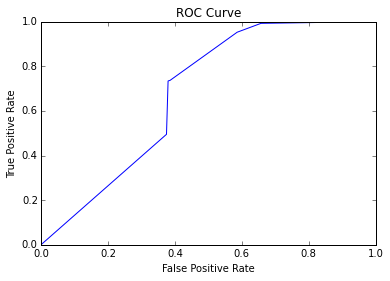

In [64]:
pl.plot(fpr,tpr)
pl.title('ROC Curve')
pl.ylabel('True Positive Rate')
pl.xlabel('False Positive Rate')
pl.show()

###Remarks

As was expected, the prediction measures increased from Linear Regression, to KNN, and then Random Forest. 

Random Forests give us satisfactory predictive power in this scenario, with an accuracy score of 82% and correlation of 88%.

Label 2, "Standing up, Walking, and going up/down stairs", is one that is not easily identified by looking at just one row of data, and would likely require a new feature that takes many consecutive seconds into account. 